In [5]:
pip install ISLP

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.6/84.6 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.5/849.5 kB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 10.3 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=49a7e42b31a59e0cecf2780991e32ba82a1e67167ce232b252b48c50f81a822a
  Stored in directory: /root/.cache/pip/wheels/50/37/21/0a719b9d89c635e89ff24bd93b862882ad675279552013b2fb
Successfully built autograd-gamma


In [6]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from ISLP import load_data
from ISLP.models import (
    ModelSpec as MS,
    summarize,
    poly
)
from sklearn.model_selection import train_test_split

In [7]:
from functools import partial
from sklearn.model_selection import (
    cross_validate,
    KFold,
    ShuffleSplit
)
from sklearn.base import clone
from ISLP.models import sklearn_sm

#Validation Set Approach

In [8]:
# Load the dataset named "Auto" using a custom function load_data()
# This function likely reads the data from a file and returns it as a DataFrame.
Auto = load_data('Auto')

In [9]:
# Display the first 5 rows of the dataset.
# This helps you quickly understand what the data looks like:
# column names, data types, any obvious issues, etc.
print(Auto.head())

                            mpg  cylinders  displacement  horsepower  weight  \
name                                                                           
chevrolet chevelle malibu  18.0          8         307.0         130    3504   
buick skylark 320          15.0          8         350.0         165    3693   
plymouth satellite         18.0          8         318.0         150    3436   
amc rebel sst              16.0          8         304.0         150    3433   
ford torino                17.0          8         302.0         140    3449   

                           acceleration  year  origin  
name                                                   
chevrolet chevelle malibu          12.0    70       1  
buick skylark 320                  11.5    70       1  
plymouth satellite                 11.0    70       1  
amc rebel sst                      12.0    70       1  
ford torino                        10.5    70       1  


In [10]:
# Show summary statistics for all numeric columns in the dataset.
# This includes count, mean, standard deviation, min, max,
# and quartiles — useful for understanding data distribution.
print(Auto.describe())

              mpg   cylinders  displacement  horsepower       weight  \
count  392.000000  392.000000    392.000000  392.000000   392.000000   
mean    23.445918    5.471939    194.411990  104.469388  2977.584184   
std      7.805007    1.705783    104.644004   38.491160   849.402560   
min      9.000000    3.000000     68.000000   46.000000  1613.000000   
25%     17.000000    4.000000    105.000000   75.000000  2225.250000   
50%     22.750000    4.000000    151.000000   93.500000  2803.500000   
75%     29.000000    8.000000    275.750000  126.000000  3614.750000   
max     46.600000    8.000000    455.000000  230.000000  5140.000000   

       acceleration        year      origin  
count    392.000000  392.000000  392.000000  
mean      15.541327   75.979592    1.576531  
std        2.758864    3.683737    0.805518  
min        8.000000   70.000000    1.000000  
25%       13.775000   73.000000    1.000000  
50%       15.500000   76.000000    1.000000  
75%       17.025000   79.0000

In [11]:
# Split the Auto dataset into two parts: training set and validation set.
# We use train_test_split() from scikit-learn for this purpose.

Auto_train, Auto_valid = train_test_split(
    Auto,

    # test_size=196 means: put exactly 196 rows into the validation set.
    # The remaining rows will go into the training set automatically.
    test_size=196,

    # random_state=0 ensures the split is reproducible.
    # If someone else runs the code with the same random_state,
    # they will get the exact same train/validation split.
    random_state=0
)


In [12]:
# 1. Initialize the Model Spec (Design Matrix Builder)
# 'MS' (likely from ISLP.models) defines which columns to use as features.
# Here, we select only 'horsepower' as our predictor.
hp_mm = MS(["horsepower"])

# 2. Create the Feature Matrix (X)
# .fit_transform() does two things:
#   a. Fits: Learns any necessary parameters (like transformations).
#   b. Transforms: Converts 'Auto_train' into a formatted matrix (X_train).
# This usually adds an intercept column automatically.
X_train = hp_mm.fit_transform(Auto_train)

# 3. Define the Target Vector (y)
# We extract the 'mpg' column as the value we want to predict.
y_train = Auto_train["mpg"]

In [13]:
# 1. Initialize the OLS Model
# 'sm.OLS' stands for Ordinary Least Squares.
# Note the order: statsmodels requires the Target (y) first, then the Features (X).
# This creates the model structure but hasn't calculated the line yet.
model = sm.OLS(y_train, X_train)

# 2. Train (Fit) the Model
# .fit() executes the math. It calculates the coefficients (beta values) that minimize the error.
# The output is stored in 'results', a wrapper containing all the statistics (R-squared, p-values, etc.).
results = model.fit()

In [14]:
# Print a comprehensive summary of the regression results
# This includes R-squared, coefficients (intercept and slope), standard errors, and p-values.
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.608
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                     300.4
Date:                Fri, 19 Dec 2025   Prob (F-statistic):           2.83e-41
Time:                        06:53:57   Log-Likelihood:                -590.83
No. Observations:                 196   AIC:                             1186.
Df Residuals:                     194   BIC:                             1192.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     39.9055      1.009     39.537      0.0

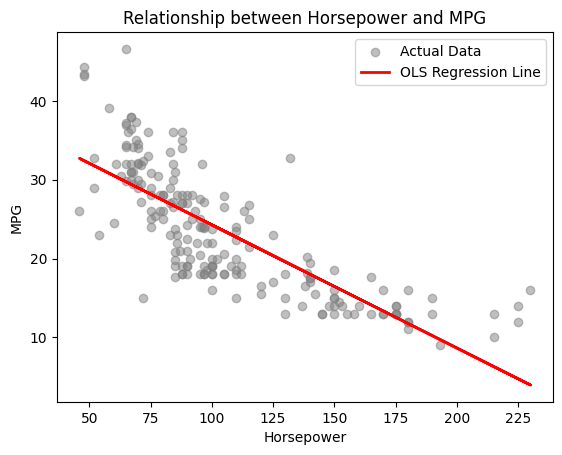

In [15]:
# 1. Create a scatter plot of the training data
# Each point represents one car in the training set.
# X-axis: horsepower
# Y-axis: mpg
# alpha=0.5 adds slight transparency so overlapping points are visible.
plt.scatter(
    Auto_train['horsepower'],
    y_train,
    color='gray',
    alpha=0.5,
    label='Actual Data'
)

# 2. Plot the fitted regression line
# We use the trained OLS model to generate predicted MPG values from X_train.
# These predictions form a smooth red line showing the model's estimated relationship.
# IMPORTANT: X_train must match what was used to fit the model (already transformed).
plt.plot(
    Auto_train['horsepower'],
    results.predict(X_train),
    color='red',
    linewidth=2,
    label='OLS Regression Line'
)

# 3. Add plot labels and legend
# Labels and title make the plot interpretable.
plt.xlabel('Horsepower')
plt.ylabel('MPG')
plt.title('Relationship between Horsepower and MPG')
plt.legend()   # Displays labels defined in the scatter and plot functions.

# 4. Render the final plot
plt.show()


In [16]:
# 1. Transform the validation data using the SAME transformation learned from training.
# IMPORTANT:
# We use .transform(), NOT .fit_transform() here because we must not re-learn parameters.
# The model should be tested on data processed in the same way as the training set.
X_valid = hp_mm.transform(Auto_valid)

# 2. Extract the true MPG values from the validation set.
# This is what we compare against the model's predictions.
y_valid = Auto_valid["mpg"]

# 3. Use the trained OLS model to predict MPG for the validation set.
# This gives the model's estimated MPG for each car.
valid_pred = results.predict(X_valid)

# 4. Compute the Mean Squared Error (MSE) on validation data.
# Formula: MSE = average of (actual - predicted)^2
# Lower MSE indicates better model performance.
print(np.mean((y_valid - valid_pred)**2))


23.61661706966988


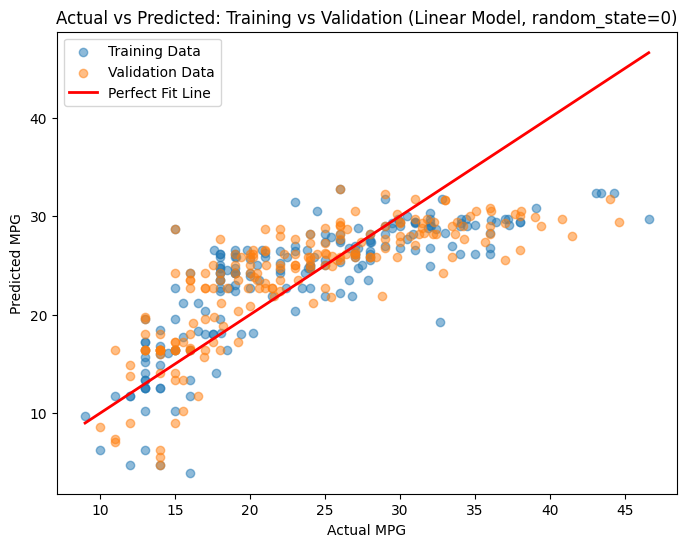

In [17]:
# Re-split the data to match the random_state=0 used for training the 'results' model
Auto_train_linear_split, Auto_valid_linear_split = train_test_split(
    Auto,
    test_size=196,
    random_state=0 # This is the random_state used for the 'results' model
)

# Re-create the Model Spec (Design Matrix Builder) for the linear model
hp_mm_linear = MS(["horsepower"])

# Re-create the Feature Matrices (X) for the linear model for both train and valid sets
X_train_linear = hp_mm_linear.fit_transform(Auto_train_linear_split)
X_valid_linear = hp_mm_linear.transform(Auto_valid_linear_split)

# Define the Target Vectors (y) for both train and valid sets, matching the split
y_train_linear = Auto_train_linear_split["mpg"]
y_valid_linear = Auto_valid_linear_split["mpg"]

# 1. Generate predictions on the training data using the fitted model
train_pred = results.predict(X_train_linear)

# 2. Generate predictions on the validation (test) data
valid_pred = results.predict(X_valid_linear)

# 3. Create a new figure with a manageable size
plt.figure(figsize=(8,6))

# 4. Scatter plot for TRAINING data
plt.scatter(
    y_train_linear, # Use the y_train corresponding to the linear split
    train_pred,
    alpha=0.5,
    label="Training Data"
)

# 5. Scatter plot for VALIDATION data
plt.scatter(
    y_valid_linear, # Use the y_valid corresponding to the linear split
    valid_pred,
    alpha=0.5,
    label="Validation Data"
)

# 6. Plot the "perfect prediction" line
plt.plot(
    [y_train_linear.min(), y_train_linear.max()],
    [y_train_linear.min(), y_train_linear.max()],
    color='red',
    linewidth=2,
    label="Perfect Fit Line"
)

# 7. Label axes and add descriptive title
plt.xlabel("Actual MPG")
plt.ylabel("Predicted MPG")
plt.title("Actual vs Predicted: Training vs Validation (Linear Model, random_state=0)")

# 8. Show legend to distinguish training vs validation points
plt.legend()

# 9. Render the final plot
plt.show()

In [18]:
def evalMSE(
    terms,      # List of predictor variable names (e.g., ["horsepower"])
    response,   # Name of the target variable (e.g., "mpg")
    train,      # Training DataFrame
    test        # Test/Validation DataFrame
):
    # 1. Initialize the transformer/scaler for selected predictor variables.
    # MS is assumed to be a custom preprocessing class.
    mm = MS(terms)

    # 2. Fit the transformer on the training data AND transform it.
    # "fit_transform" learns parameters (like mean, scaling, smoothing)
    # from the training set and applies the transformation.
    X_train = mm.fit_transform(train)

    # 3. Extract the response values (target variable) from the training data.
    y_train = train[response]

    # 4. Transform the test data using the SAME parameters learned from training.
    # IMPORTANT: We must NOT re-fit on test data.
    X_test = mm.transform(test)

    # 5. Extract the true test-set response values for evaluation.
    y_test = test[response]

    # 6. Fit an OLS regression model using statsmodels.
    # WARNING: statsmodels OLS does NOT automatically add an intercept.
    results = sm.OLS(y_train, X_train).fit()

    # 7. Predict the response variable for the test set.
    test_pred = results.predict(X_test)

    # 8. Compute and return Mean Squared Error (MSE):
    #     MSE = average of (actual - predicted)^2
    return np.mean((y_test - test_pred)**2)


In [19]:
# Create an empty array of length 3 to store MSE values
# Each entry will correspond to polynomial degree 1, 2, and 3
MSE = np.zeros(3)

# Loop over polynomial degrees 1, 2, and 3
for idx, degree in enumerate(range(1, 4)):

    # Evaluate the model's MSE for a polynomial of the given degree.
    # poly("horsepower", degree) automatically creates polynomial features:
    #   degree=1 → horsepower
    #   degree=2 → horsepower + horsepower^2
    #   degree=3 → horsepower + horsepower^2 + horsepower^3
    #
    # evalMSE() trains the model on Auto_train and evaluates MSE on Auto_valid.
    MSE[idx] = evalMSE(
        [poly("horsepower", degree)],  # predictor terms
        "mpg",                         # response variable
        Auto_train,                    # training dataset
        Auto_valid                     # validation dataset
    )

# Print the MSE values for degree 1, 2, and 3
print(MSE)


[23.61661707 18.76303135 18.79694163]


##What This Code Is Doing Conceptually

1. Testing three different models

- Linear model (degree = 1)

- Quadratic curve (degree = 2)

- Cubic curve (degree = 3)

2. Measuring how well each model predicts mpg using MSE.

3. Saving MSE scores into a NumPy array so you can see whether adding more polynomial terms improves or harms generalization.

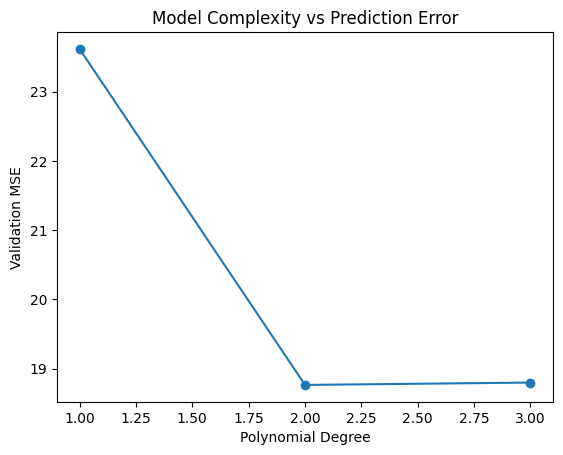

In [20]:
plt.plot([1,2,3], MSE, marker='o')
plt.xlabel("Polynomial Degree")
plt.ylabel("Validation MSE")
plt.title("Model Complexity vs Prediction Error")
plt.show()

What This Graph Shows

- X-axis: model complexity

- Y-axis: validation error (MSE)

- A downward trend means increasing degree improves the fit.

- An upward trend means overfitting has begun.

- A flat region means adding complexity does not help.

- This helps choose the best polynomial degree.

In [21]:
# 1. Re-split the data into Training and Validation sets
# test_size=196 means exactly 196 rows go into Auto_valid.
# random_state=3 ensures the split is reproducible.
Auto_train, Auto_valid = train_test_split(
    Auto,
    test_size=196,
    random_state=3
)

# 2. Create an array to store MSE results for polynomial degrees 1, 2, and 3.
MSE = np.zeros(3)

# 3. Loop over polynomial degrees 1 → 3
for idx, degree in enumerate(range(1, 4)):

    # evalMSE() does the following:
    #   - builds polynomial features (e.g., hp, hp^2, hp^3)
    #   - fits an OLS regression model on Auto_train
    #   - predicts mpg on Auto_valid
    #   - returns validation MSE
    MSE[idx] = evalMSE(
        [poly("horsepower", degree)],  # predictor specification
        "mpg",                         # target variable
        Auto_train,                    # training data
        Auto_valid                     # validation data
    )

# 4. Display the three MSE values: one for each polynomial degree
print(MSE)


[20.75540796 16.94510676 16.97437833]


In [22]:
# 1. Re-split the data into Training and Validation sets
# test_size=196 means exactly 196 rows go into Auto_valid.
# random_state=3 ensures the split is reproducible.
Auto_train, Auto_valid = train_test_split(
    Auto,
    test_size=196,
    random_state=3
)

# 2. Create an array to store MSE results for polynomial degrees 1, 2, and 3.
MSE = np.zeros(3)

# 3. Loop over polynomial degrees 1 → 3
for idx, degree in enumerate(range(1, 4)):

    # evalMSE() does the following:
    #   - builds polynomial features (e.g., hp, hp^2, hp^3)
    #   - fits an OLS regression model on Auto_train
    #   - predicts mpg on Auto_valid
    #   - returns validation MSE
    MSE[idx] = evalMSE(
        [poly("horsepower", degree)],  # predictor specification
        "mpg",                         # target variable
        Auto_train,                    # training data
        Auto_valid                     # validation data
    )

# 4. Display the three MSE values: one for each polynomial degree
print(MSE)


[20.75540796 16.94510676 16.97437833]


Interpretation:

- Degree 1 (linear): MSE ≈ 20.75
Model is too simple → underfitting.

- Degree 2 (quadratic): MSE ≈ 16.94
Best performance → captures curvature but not too flexible.

- Degree 3 (cubic): MSE ≈ 16.97
Almost same as degree 2 but slightly worse → small overfitting.

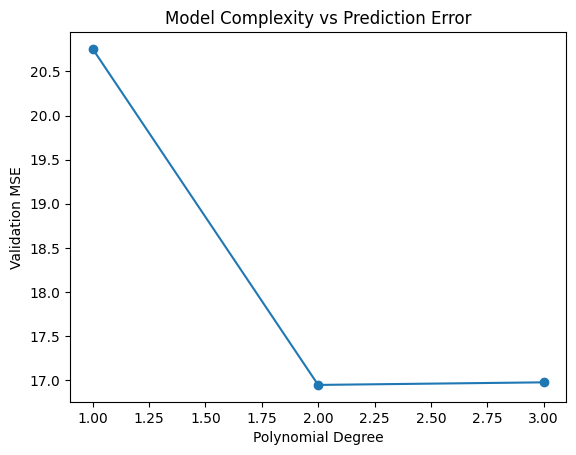

In [23]:
plt.plot([1, 2, 3], MSE, marker='o')
plt.xlabel("Polynomial Degree")
plt.ylabel("Validation MSE")
plt.title("Model Complexity vs Prediction Error")
plt.show()


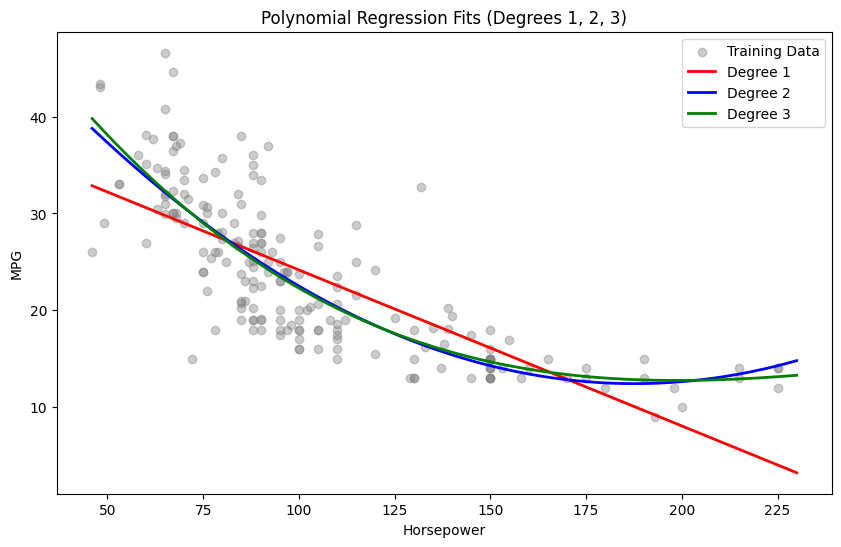

In [24]:
# 1. Make a smooth range of horsepower values for drawing the curves
hp_grid = np.linspace(Auto["horsepower"].min(), Auto["horsepower"].max(), 300)

plt.figure(figsize=(10, 6))

# 2. Plot the actual data points
plt.scatter(Auto_train["horsepower"], Auto_train["mpg"],
            color="gray", alpha=0.4, label="Training Data")

# 3. Loop over polynomial degrees 1, 2, 3
colors = ["red", "blue", "green"]

for degree, color in zip([1, 2, 3], colors):

    # Create polynomial terms on the grid
    mm = MS([poly("horsepower", degree)])
    X_train = mm.fit_transform(Auto_train)  # fit on training data
    X_grid = mm.transform(pd.DataFrame({"horsepower": hp_grid}))  # transform grid

    # Fit OLS model
    model = sm.OLS(Auto_train["mpg"], X_train).fit()

    # Predict on the grid for smooth curves
    mpg_pred = model.predict(X_grid)

    # Plot this polynomial curve
    plt.plot(hp_grid, mpg_pred, color=color, linewidth=2,
             label=f"Degree {degree}")

# 4. Final plot formatting
plt.xlabel("Horsepower")
plt.ylabel("MPG")
plt.title("Polynomial Regression Fits (Degrees 1, 2, 3)")
plt.legend()
plt.show()


#Cross Validation

In [25]:
# Create a scikit-learn–compatible model wrapper around statsmodels OLS.
# - sm.OLS is the regression algorithm
# - MS(['horsepower']) defines how predictors are transformed/selected
hp_model = sklearn_sm(
    sm.OLS,
    MS(['horsepower'])
)

##What this does conceptually
We are creating a linear regression model that:

- Uses horsepower as the only predictor

- Uses OLS (Ordinary Least Squares) for fitting

- Is wrapped so it can work with scikit-learn tools like cross-validation

In [26]:
# Prepare the Full Dataset
# We use the *entire* 'Auto' dataset here, not just a training chunk.
# X: All columns except 'mpg'. Y: Only the 'mpg' column.
X, Y = Auto.drop(columns=['mpg']), Auto['mpg']

In [27]:
# Run Cross-Validation
# This is the critical step.
# cv=Auto.shape[0] means "Set the number of folds equal to the number of rows".
# This forces "Leave-One-Out Cross-Validation" (LOOCV).
cv_results = cross_validate(
    hp_model,
    X,
    Y,
    cv=Auto.shape[0] # e.g., if you have 392 cars, it trains 392 times!
)

## Why `cv=Auto.shape[0]` matters

- Auto.shape[0] = number of observations

- This means: Leave-One-Out Cross-Validation (LOOCV)

For each observation:

1. Train the model on all other observations

2. Test on the single left-out observation

3. Repeat for every row

This gives a nearly unbiased estimate of test error.

In [28]:
# Calculate Average Error
# We take the average of all 392 test scores to get a single, very stable error metric.
cv_err = np.mean(cv_results['test_score'])
print(cv_err)

24.23151351792922


- test_score contains one error per left-out observation

- Taking the mean gives the LOOCV estimate of prediction error

In [29]:
# 1. Initialize Error Storage
# Creates an array [0.0, 0.0, 0.0, 0.0, 0.0] to hold the error for degrees 1 through 5.
cv_error = np.zeros(5)
# This array will store the average LOOCV error for each polynomial degree.

# 2. Extract Predictor Variable
# Gets the 'horsepower' column as a numpy array for easier mathematical manipulation.
H = np.array(Auto["horsepower"])

# 3. Initialize Model Wrapper
# Creates the statsmodels OLS wrapper (without a specific formula yet).
# This allows sm.OLS to work with cross_validate().
M = sklearn_sm(sm.OLS)

# 4. Loop over Polynomial Degrees 1 to 5
# enumerates: i=0 (degree 1), i=1 (degree 2), etc.
# i is the index used to store results in cv_error.

for i, d in enumerate(range(1, 6)):

    # 5. Create Polynomial Features Manually
    # This matrix trick creates columns for [H^0, H^1, ..., H^d]
    # e.g., for d=2, it creates columns: [1 (intercept), horsepower, horsepower^2]
    X = np.power.outer(H, np.arange(d+1))

    # 6. Run Cross-Validation (LOOCV)
    # Trains the model N times (once for every row in Auto), leaving one row out each time.
    M_CV = cross_validate(
        M,
        X,
        Y,              # The Target (MPG)
        cv=Auto.shape[0] # cv=N forces Leave-One-Out validation
    )

    # 7. Store Average Error
    # Calculates the mean test score (MSE) across all N folds for this specific degree.
    cv_error[i] = np.mean(M_CV['test_score'])

# 8. Print Results
# Displays the 5 MSE values. You look for the "elbow" or minimum value here.
print(cv_error)

[24.23151352 19.24821312 19.33498406 19.42443029 19.03320648]


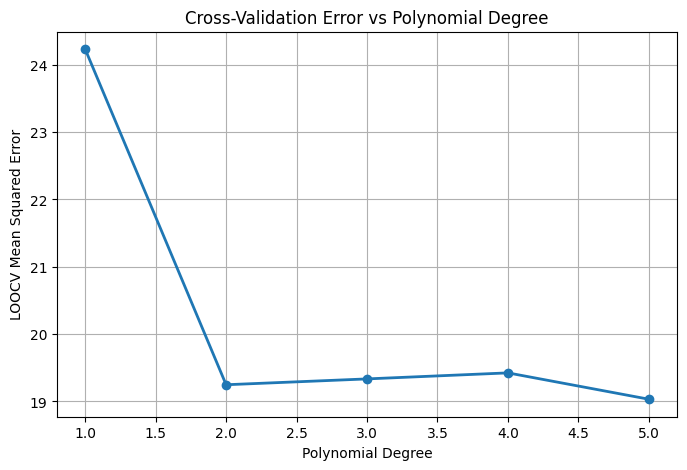

In [30]:
# Create an array of polynomial degrees (1 through 5)
# This will be used for the x-axis of the plot
degrees = np.arange(1, 6)

# Create a new figure with a fixed size
plt.figure(figsize=(8, 5))

# Plot LOOCV error against polynomial degree
# marker='o' shows points clearly
# linewidth=2 makes the line easier to read
plt.plot(degrees, cv_error, marker='o', linewidth=2)

# Label the x-axis
plt.xlabel("Polynomial Degree")

# Label the y-axis
plt.ylabel("LOOCV Mean Squared Error")

# Add a descriptive title
plt.title("Cross-Validation Error vs Polynomial Degree")

# Add a grid to improve readability
plt.grid(True)

# Display the plot
plt.show()


In [31]:
A = np.array([3, 5, 9])
B = np.array([2, 4])
np. add.outer(A, B)

array([[ 5,  7],
       [ 7,  9],
       [11, 13]])

In [32]:
from sklearn.model_selection import KFold

# 1. Initialize Error Storage
# Arrays to hold the Mean Squared Error (MSE) for degrees 1 through 5.
cv_error = np.zeros(5)

# 2. Define the Cross-Validation Strategy (K-Fold)
# instead of cv=392 (LOOCV), we use n_splits=10.
# shuffle=True: Vital! It mixes the data before splitting. If data is sorted (e.g., by MPG),
#               not shuffling would lead to biased folds (e.g., Fold 1 has only low MPG cars).

cv = KFold(
    n_splits=10, #splits in 10 parts; each fold is used once as validation & results are validated
    shuffle=True,
    random_state=0 #Ensures we get the exact same "random" shuffle every time we run this
)

# 3. Loop Through Polynomial Degrees (1 to 5)
for i, d in enumerate(range(1, 6)):

    # 4. Create Polynomial Features Manually
    # Generates a matrix with columns [H^0, H^1, ..., H^d]
    X = np.power.outer(H, np.arange(d+1))

    # 5. Run Cross-Validation
    # We pass the 'cv' object we created in step 2.
    # This divides the data into 10 chunks. It trains on 9 chunks (90%) and tests on 1 (10%),
    # repeating this process 10 times.
    M_CV = cross_validate(
        M,
        X,
        Y,
        cv=cv
    )

    # 6. Calculate Average Error
    # Averages the 10 test scores to get a stable estimate of model performance.
    cv_error[i] = np.mean(M_CV['test_score'])

# 7. Print Results
print(cv_error)

[24.20766449 19.18533142 19.27626666 19.47848403 19.13720065]


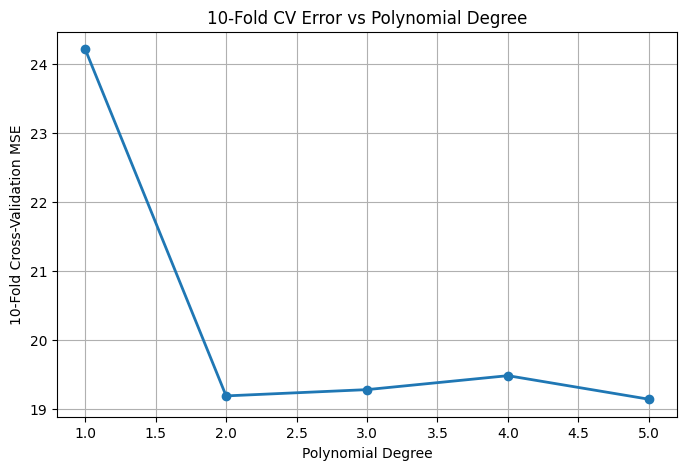

In [33]:
# Polynomial degrees tested (1 through 5)
degrees = np.arange(1, 6)

# Create the plotting canvas
plt.figure(figsize=(8, 5))

# Plot cross-validation error versus polynomial degree
# marker='o' makes each degree's result visible
plt.plot(degrees, cv_error, marker='o', linewidth=2)

# Label axes
plt.xlabel("Polynomial Degree")
plt.ylabel("10-Fold Cross-Validation MSE")

# Add plot title
plt.title("10-Fold CV Error vs Polynomial Degree")

# Add grid for readability
plt.grid(True)

# Display the plot
plt.show()


How to Interpret the Plot

- X-axis → polynomial degree (model complexity)

- Y-axis → estimated test error

Decision rule:

- Find the lowest point

- That degree is the best model

Typical behavior:

- Low degree → underfitting

- High degree → overfitting

- Minimum → optimal bias–variance trade-off

In [34]:

# 1. Define the Split Strategy
# ShuffleSplit randomly shuffles the data and then splits it.
# n_splits=1: CRITICAL. This means we are NOT doing repeated cross-validation.
#             We are doing exactly ONE split (just like train_test_split).
# test_size=196: We set aside 196 rows for validation.
validation = ShuffleSplit(
    n_splits=1,
    test_size=196,
    random_state=0
)

# 2. Run the "Validation"
# Even though the function is called 'cross_validate', because our 'cv' object
# only has 1 split, it will only train the model ONCE and test it ONCE.
results = cross_validate(
    hp_model,
    Auto.drop(["mpg"], axis =1), # Features (X)
    Auto["mpg"],                 # Target (y)
    cv=validation
)

# 3. View the Score
# This prints the score for that single split.
# Note: Since there is only 1 split, this array will have a length of 1.

In [35]:
print("Validation MSE:", results["test_score"][0])

Validation MSE: 23.61661706966988


---

## How to Interpret `results["test_score"]`

Because we  used **only one split**:

* This is **not cross-validation in the usual sense**
* It is a **single validation-set estimate**
* The result depends on which 196 observations were randomly chosen



In [36]:
# 1. Define the Split Strategy
# ShuffleSplit creates random permutations.
# n_splits=10: We will repeat the "split and test" process 10 separate times.
# test_size=196: In EACH split, 196 randomly chosen cars are set aside for validation.
# random_state=0: Ensures the sequence of random splits is reproducible.
validation = ShuffleSplit(
    n_splits=10,
    test_size=196,
    random_state=0
)

# 2. Run Cross-Validation
# This loop runs 10 times. In each iteration:
#   a. It shuffles the data and picks 196 new validation rows.
#   b. It trains the model on the remaining rows.
#   c. It scores the model on the 196 validation rows.
results = cross_validate(
    hp_model,
    Auto.drop(["mpg"], axis =1),
    Auto["mpg"],
    cv=validation
)

# 3. Analyze Stability
# .mean(): The average performance across the 10 runs.
# .std(): The Standard Deviation. This tells you how "lucky" or "unlucky" the splits were.
#         A high std means your model's score varies wildly depending on which cars are picked.
print("Mean MSE is approximately ", results["test_score"].mean())
print("Standard Deviation of MSE is approximately", results["test_score"].std())

Mean MSE is approximately  23.802232661034168
Standard Deviation of MSE is approximately 1.4218450941091842


## What this tells you:

- Lower mean → better model

- Smaller std → more stable model

A large std means the model’s performance heavily depends on which observations are held out.

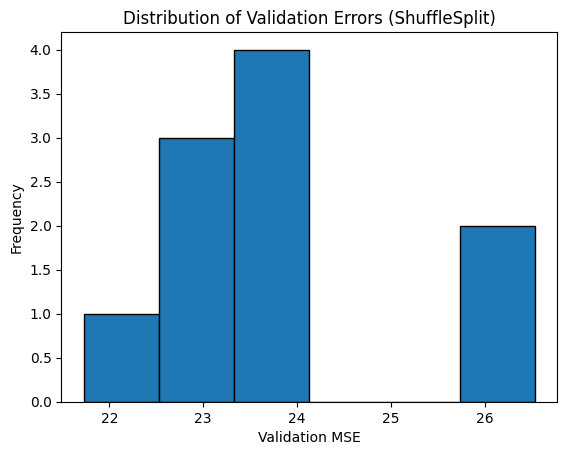

In [37]:
import matplotlib.pyplot as plt

plt.hist(results["test_score"], bins=6, edgecolor='black')
plt.xlabel("Validation MSE")
plt.ylabel("Frequency")
plt.title("Distribution of Validation Errors (ShuffleSplit)")
plt.show()


---

## Model Evaluation Methods – Detailed Comparison

| Aspect                         | **Single Validation Split**                    | **ShuffleSplit (Repeated Hold-Out)**                   | **K-Fold Cross-Validation**                                | **LOOCV (Leave-One-Out CV)**                |
| ------------------------------ | ---------------------------------------------- | ------------------------------------------------------ | ---------------------------------------------------------- | ------------------------------------------- |
| **Core Idea**                  | Split data once into train and validation sets | Randomly split data multiple times and average results | Split data into *K* equal folds and rotate validation fold | Leave exactly one observation out each time |
| **# of Model Fits**            | 1                                              | `n_splits` (e.g., 10)                                  | `K` (usually 5 or 10)                                      | `n` (number of observations)                |
| **Training Set Size**          | `n − test_size`                                | `n − test_size`                                        | `(K−1)/K × n`                                              | `n − 1`                                     |
| **Validation Set Size**        | `test_size`                                    | `test_size`                                            | `n / K`                                                    | 1                                           |
| **Randomness**                 | High (depends on split)                        | Medium (averaged over splits)                          | Low (deterministic unless shuffled)                        | None                                        |
| **Bias of Error Estimate**     | Medium                                         | Low                                                    | Low                                                        | Very low                                    |
| **Variance of Error Estimate** | High                                           | Medium                                                 | Medium                                                     | High                                        |
| **Stability of Result**        | Poor                                           | Good                                                   | Very good                                                  | Medium                                      |
| **Computational Cost**         | Very low                                       | Low–Medium                                             | Medium                                                     | Very high                                   |
| **Speed**                      | Fastest                                        | Fast                                                   | Moderate                                                   | Slowest                                     |
| **Overfitting Detection**      | Weak                                           | Moderate                                               | Strong                                                     | Strong                                      |
| **Sensitivity to Outliers**    | High                                           | Medium                                                 | Low                                                        | Very high                                   |
| **Data Efficiency**            | Poor (many points unused for training)         | Moderate                                               | Good                                                       | Excellent                                   |
| **Interpretability**           | Simple                                         | Simple                                                 | Standard                                                   | Conceptually simple but expensive           |
| **Implementation Difficulty**  | Very easy                                      | Easy                                                   | Easy                                                       | Moderate                                    |
| **Common scikit-learn Tool**   | `train_test_split`                             | `ShuffleSplit`                                         | `KFold`                                                    | `KFold(n_splits=n)`                         |
| **When Results Vary a Lot**    | Always                                         | Sometimes                                              | Rarely                                                     | Often                                       |

---

## Bias–Variance Intuition (Critical Concept)

| Method           | Bias     | Variance | Why                                 |
| ---------------- | -------- | -------- | ----------------------------------- |
| **Single Split** | Moderate | High     | Depends heavily on one random split |
| **ShuffleSplit** | Low      | Medium   | Averaging reduces randomness        |
| **K-Fold CV**    | Low      | Medium   | Balanced reuse of data              |
| **LOOCV**        | Very low | High     | Training sets are almost identical  |

---

## When to Use Each Method (Practical Guidance)

### ✅ Single Split

Use when:

* Dataset is **very large**
* You need a **quick sanity check**
* Speed matters more than precision

Avoid when:

* Dataset is small
* Model selection matters

---

### ✅ ShuffleSplit

Use when:

* You want **uncertainty estimates** (mean ± std)
* Dataset is small to medium
* You want randomness but controlled

Common in:

* Model benchmarking
* Sensitivity analysis

---

### ✅ K-Fold Cross-Validation (Recommended Default)

Use when:

* You want a **reliable, standard method**
* Dataset is small or medium
* You are selecting model complexity

This is the **industry default** (usually K = 5 or 10).

---

### ✅ LOOCV

Use when:

* Dataset is **very small**
* You want **maximum training data**
* Model is cheap to train

Avoid when:

* Dataset is large
* Model is computationally expensive
* High variance is problematic

---

## Accuracy vs Speed Trade-Off

```
Accuracy ↑
LOOCV
   |
   |      K-Fold
   |   ShuffleSplit
   | Single Split
   ----------------------→ Speed
```

---

## Final Recommendation (Rule of Thumb)

| Scenario                | Best Choice   |
| ----------------------- | ------------- |
| Quick experiment        | Single Split  |
| Stability + uncertainty | ShuffleSplit  |
| Model selection         | **K-Fold CV** |
| Very small dataset      | LOOCV         |

---


#Bootstrap


In [38]:
# Load the dataset named "Portfolio"
# This dataset typically contains two asset returns: X and Y
Portfolio = load_data('Portfolio')
print(Portfolio.head())

          X         Y
0 -0.895251 -0.234924
1 -1.562454 -0.885176
2 -0.417090  0.271888
3  1.044356 -0.734198
4 -0.315568  0.841983


In [39]:
def alpha_func(D, idx):
    """
    This function is designed for Bootstrapping (resampling) and computes the
    optimal portfolio weight (alpha) for asset X based on variance–covariance
    relationships.

    Parameters:
    D   : DataFrame containing columns 'X' and 'Y' (asset returns)
    idx : Indices specifying which rows of D to use (e.g., a bootstrap sample)

    Returns:
    alpha : Optimal weight assigned to asset X
    """

    # 1. Compute the variance–covariance matrix of X and Y
    # - D[['X','Y']] selects the two asset return columns
    # - .loc[idx] selects only the rows specified by idx
    # - rowvar=False means each column represents a variable
    # Output 'cov_' is a 2x2 matrix:
    # [[Var(X),    Cov(X,Y)],
    #  [Cov(Y,X),  Var(Y)]]
    cov_ = np.cov(
        D[['X', 'Y']].loc[idx],
        rowvar=False
    )

    # 2. Compute and return the optimal portfolio weight (alpha)
    # We extract specific values from the 2x2 matrix to use in the minimization formula.
    # cov_[0,0] → Var(X)
    # cov_[1,1] → Var(Y)
    # cov_[0,1] → Cov(X, Y)
    #
    # Formula:
    # alpha = (Var(Y) − Cov(X, Y)) /
    #         (Var(X) + Var(Y) − 2·Cov(X, Y))
    #
    # This minimizes the variance of a two-asset portfolio.
    return (
        (cov_[1, 1] - cov_[0, 1]) /
        (cov_[0, 0] + cov_[1, 1] - 2 * cov_[0, 1])
    )


This function implements the formula for finding the minimum variance portfolio of two assets. The mathematical equation for $\alpha$ (the fraction invested in X) is:

$$\alpha = \frac{\sigma_Y^2 - \sigma_{XY}}{\sigma_X^2 + \sigma_Y^2 - 2\sigma_{XY}}$$

Where:
- $\sigma_X^2$ is cov_[0,0] (Variance of X)
- $\sigma_Y^2$ is cov_[1,1] (Variance of Y)
- $\sigma_{XY}$ is cov_[0,1] (Covariance)

> **Why idx?**

The presence of the idx argument strongly suggests this code is part of a Bootstrap exercise.
- **Without Bootstrap**: You calculate $\alpha$ once on the whole dataset.
- **With Bootstrap**: You generate 1,000 random lists of indices (idx), run this function 1,000 times, and get the Standard Error of your $\alpha$ estimate.
- This is especially useful when estimating uncertainty

In [40]:
# Call the alpha_func to calculate the optimal investment ratio.
# Portfolio: The dataframe containing the X and Y return data.
# range(100): A sequence of integers from 0 to 99.
#             This tells the function to ONLY look at the first 100 rows
#             of the dataset to calculate the covariance and alpha.
alpha_func(Portfolio, range(100))

np.float64(0.57583207459283)

The returned number is a single scalar:

> 0.575


Meaning:

- Invest 57.5% in asset X

- Invest 42.5% in asset Y

to achieve the minimum-variance portfolio, based only on the first 100 observations.

In [41]:
# 1. Initialize Random Number Generator
# We use the modern 'default_rng' with a seed of 0.
# This ensures that the sequence of "random" numbers is exactly the same every time you run this.
rng = np.random.default_rng(0)

# 2. Call the Alpha Function
alpha_func(
    Portfolio,
    # 3. Generate Bootstrap Indices
    # rng.choice creates a list of random indices to select rows from Portfolio.
    rng.choice(
        100,           # The pool to choose from: Integers 0 to 99 (assuming Portfolio has 100 rows).
        100,           # The sample size: We want 100 indices back.
        replace=True   # CRITICAL: "With Replacement".
                       # This means the same row (e.g., Row #42) can be picked 2 or 3 times,
                       # while other rows might be left out completely.
    )
)

np.float64(0.6074452469619004)

## Key Concept: Sampling With Replacement

The `replace=True` parameter is the heart of the Bootstrap method.
- Without Replacement: You would just get the numbers 0-99 shuffled. The data would be identical to the original, just reordered. The $\alpha$ would be exactly the same.
- With Replacement: By allowing duplicates, you create a "new" dataset that mimics the variation you might see in the real world.
- Example: Your list of indices might look like $[0, 5, 5, 2, 99, 5, ...]$. Note that row 5 appears three times!
-The Result:This code returns one estimate of $\alpha$ (e.g., 0.60). This single number isn't very useful on its own.

In [42]:
def boot_SE(func, D, n=None, B=1000, seed=0):
    # 1. Setup Random Generator
    # Initialize the generator with a fixed seed for reproducibility.
    rng = np.random.default_rng(seed)

    # 2. Initialize Accumulators
    # Instead of storing a list of 1000 numbers (which takes memory),
    # we just keep running totals of the Sum (first_) and Sum-of-Squares (second_).
    first_, second_ = 0, 0

    # 3. Determine Sample Size
    # If 'n' is not provided, default to using the total number of rows in D.
    n = n or D.shape[0]

    # 4. The Bootstrap Loop
    # Repeat the process B times (default 1000).
    for _ in range(B):

        # a. Resample (With Replacement)
        # Randomly pick 'n' indices from the dataframe D.
        idx = rng.choice(D.index, n, replace=True)

        # b. Calculate the Statistic
        # Run the custom function (like 'alpha_func') on this new synthetic dataset.
        value = func(D, idx)

        # c. Update Accumulators
        # Add the raw value to the first accumulator.
        first_ += value
        # Add the squared value to the second accumulator.
        second_ += value**2

    # 5. Calculate Standard Error
    # This formula is derived from the definition of Variance: Var(X) = E[X^2] - (E[X])^2
    # Standard Deviation (SE) is the square root of Variance.
    # second_/B represents E[X^2] (Average of squares)
    # first_/B  represents E[X]   (Average of values)
    return np.sqrt(second_ / B - (first_ / B)**2)

## What This Function Does (Conceptually)

This function computes the **bootstrap standard error** of a statistic.

In words:

1. Repeatedly resample the data with replacement
2. Recompute the statistic on each resample
3. Measure how much the statistic varies across resamples

That variability is the **standard error**.

---

## What Each Parameter Means

| Parameter | Meaning                                 |
| --------- | --------------------------------------- |
| `func`    | Statistic function (e.g., `alpha_func`) |
| `D`       | Dataset                                 |
| `n`       | Size of each bootstrap sample           |
| `B`       | Number of bootstrap replications        |
| `seed`    | Ensures reproducible results            |

---

## Why the Formula Works

The function computes:

[
\text{SE} = \sqrt{ \mathbb{E}[T^2] - (\mathbb{E}[T])^2 }
]

where:

* (T) is the bootstrap estimate
* Expectations are approximated using averages over `B` samples

This is the **population standard deviation formula**, applied to bootstrap estimates.

---

## Typical Usage Example

```python
boot_SE(alpha_func, Portfolio)
```

This returns the **standard error of the optimal portfolio weight α**.

---

## Key Takeaway

* This function measures **estimation uncertainty**
* It works for **any statistic**, not just portfolios
* It avoids analytical variance formulas
* It is a **core bootstrap technique** in statistics and ML

---


In [43]:
# 1. Run the Bootstrap Standard Error Function
# We call the generic 'boot_SE' function we defined earlier.
alpha_SE = boot_SE(
    alpha_func,   # The specific logic we want to test (calculating alpha).
    Portfolio,    # The dataset to sample from.
    B=1000,       # The number of times to repeat the experiment (1000 is standard).
    seed=0        # Ensures we get the same "random" samples every time we run this.
)

# 2. Display the Result
# This outputs the calculated Standard Error (e.g., 0.09).
alpha_SE

np.float64(0.09118176521277699)

##What does the result alpha_SE tell you?
1.  Precision: It tells you how much your estimated $\alpha$ (optimal investment share) would likely vary if you had collected a different dataset of stock returns.

2. Accuracy vs. Stability:

- Low SE (e.g., 0.01): Your estimate is very stable. You can confidently tell a client to invest 60% in Asset X.

- High SE (e.g., 0.20): Your estimate is shaky. One day the math says "Invest 60%," but with slightly different data, it might say "Invest 20%."

### Practical Application: Confidence Intervals

Now that you have the Standard Error, you can construct a 95% Confidence Interval for your $\alpha$ estimate without needing complex formulas.

$$\text{CI} \approx \hat{\alpha} \pm 2 \times \text{SE}$$

If your original $\alpha$ was 0.6 and your alpha_SE is 0.09:

Range: $0.6 \pm 0.18$

Result: You can be 95% confident the true optimal share is between 0.42 and 0.78.



In [44]:
# 1. Define the Bootstrap Function for OLS
# model_matrix: The design matrix builder (likely an ISLP 'MS' object).
# response: The name of the target column (e.g., 'mpg').
# D: The full dataframe.
# idx: The list of random row indices for this specific bootstrap iteration.
def boot_OLS(model_matrix, response, D, idx):

    # 2. Resample the Data
    # specific rows are selected based on the random 'idx' passed in.
    # Since 'idx' has duplicates (replace=True), D_ is a synthetic dataset.
    D_ = D.loc[idx]

    # 3. Extract the Target (Y)
    # Get the correct answers for this resampled batch.
    Y_ = D_[response]

    # 4. Create the Features (X)
    # clone(model_matrix): Creates a fresh copy of the transformer so we don't mess up the original.
    # .fit_transform(D_): Crucial! We re-learn the transformations (like means or categories)
    # specific to THIS bootstrap sample. This captures the full uncertainty of the modeling process.
    X_ = clone(model_matrix).fit_transform(D_)

    # 5. Fit OLS and Return Coefficients
    # We train a new regression model on this specific random sample.
    # .params: We strictly return the coefficients (Intercept, Slope).
    # We do NOT return the full model object, just the numbers we want to analyze.
    return sm.OLS(Y_, X_).fit().params

In [45]:
# Create a partially-applied function using functools.partial
# This "pre-fills" some arguments of boot_OLS so we don’t have to pass them every time

hp_func = partial(
    boot_OLS,                  # Original function used inside bootstrap
    MS(['horsepower']),        # Fix the model matrix:
                               # MS(['horsepower']) creates a design matrix
                               # using 'horsepower' as the predictor
    'mpg'                      # Fix the response variable:
                               # 'mpg' is the target variable we want to predict
)

# After this, hp_func becomes a new function that only needs:
#   - D   : the dataset
#   - idx : bootstrap resampled indices
#
# Effectively, this is equivalent to defining:
#
# def hp_func(D, idx):
#     return boot_OLS(MS(['horsepower']), 'mpg', D, idx)
#
# This makes hp_func directly usable inside a bootstrap loop,
# where D and idx change each iteration, but the model structure stays the same.


## Why do we do this?
We do this to make `hp_func` compatible with your `boot_SE` function.

- `boot_SE` looks like this:` def boot_SE(func, D, ...)`

- It tries to call `func(D, idx)`.

- If you passed the raw `boot_OLS`, it would crash because `boot_SE` doesn't know what "horsepower" or "mpg" are.

- By using partial, you package those details inside `hp_func`, so `boot_SE` can just simply pass the data and index.

In [50]:
# Create a random number generator with a fixed seed
# Using a fixed seed ensures reproducibility:
# the same "random" bootstrap samples are generated every time
rng = np.random.default_rng(0)

# Perform bootstrap resampling 10 times
# In each iteration:
#   1. Draw 392 indices WITH replacement from the range [0, 391]
#      (392 is the number of observations in the Auto dataset)
#   2. Pass these indices to hp_func
#   3. hp_func fits an OLS model on the resampled data
#      and returns the estimated regression coefficients
#   4. Collect the coefficients into a NumPy array
bootstrap_coefficients = np.array([
    hp_func(
        Auto,                               # Original dataset
        rng.choice(                         # Bootstrap sampling
            Auto.index,                     # Use the actual index labels from Auto
            392,                            # Sample size (same as original)
            replace=True                   # Sampling with replacement
        )
    )
    for _ in range(10)                      # Repeat bootstrap 10 times
])

# Result:
# bootstrap_coefficients is a 2D NumPy array:
#   - Each row corresponds to one bootstrap sample
#   - Each column corresponds to a regression coefficient
#     (intercept and horsepower slope)
#
# Shape: (10, number_of_coefficients)


## Interpreting the Output

The result will be a 10x2 Matrix (10 rows, 2 columns).

1. Rows (10): Each row represents a different "simulated reality" (a different bootstrap sample).
2. Columns (2):
- Column 0: The Intercept ($\beta_0$) calculated for that sample.
- Column 1: The Horsepower Slope ($\beta_1$) calculated for that sample.

You will see the numbers changing slightly row by row. This variation is exactly what we measure to calculate the **Standard Error**.

In [51]:
# 1. Execute Bootstrap for Standard Errors
# We call our custom boot_SE function using the 'hp_func' logic we created earlier.
# This will:
#   a. Create 1,000 synthetic datasets (B=1000) by resampling 'Auto'.
#   b. Fit a Linear Regression on EACH dataset.
#   c. Calculate the standard deviation of the resulting coefficients.
hp_se = boot_SE(
    hp_func,
    Auto,
    B=1000,
    seed=10  # A different seed than before, just to show it's adjustable.
)

# 2. View the Standard Errors
# The output will contain two numbers:
#   1. The Standard Error of the Intercept.
#   2. The Standard Error of the Horsepower coefficient.
print(hp_se)

,0
intercept,0.731176
horsepower,0.006092


#Interpreting the Output

You will get a Pandas Series (or array) with two values. These values represent **Uncertainty**.

- **Intercept SE**: How much the "baseline MPG" wiggles around if you change the data slightly.

- **Horsepower SE**: How much the "effect of horsepower on MPG" wiggles around.

**Why is this cool?** In standard regression `(model.summary())`, the Standard Errors are calculated using formulas that assume your data follows a Normal Distribution (Gaussian). **Bootstrap SEs** (what you just calculated) are calculated by brute-force simulation. They do **not** rely on those assumptions. If the Bootstrap SEs are very different from the Standard SEs, it implies your data might not be "normal" (e.g., it might have outliers or non-linear patterns).

In [52]:
# 1. Fit the Model to the Full Dataset
# We fit the 'hp_model' (Linear Regression) on the entire 'Auto' dataset.
# Features: Auto (automatically handles the 'horsepower' column via the pipeline)
# Target: Auto['mpg']
hp_model.fit(Auto, Auto['mpg'])

# 2. Extract Standard Errors
# hp_model.results_: Accesses the internal statsmodels result object.
# summarize(...): A helper function (likely from ISLP) that converts the messy
#                 results into a clean Pandas DataFrame.
# ['std err']: We slice that DataFrame to get ONLY the Standard Error column.
model_se = summarize(hp_model.results_)['std err']

# 3. Display the Result
# This prints the Standard Errors for the Intercept and Horsepower.
model_se

,std err
intercept,0.717
horsepower,0.006


## The "Aha!" Moment: Theoretical vs. Bootstrap

This step is the punchline of your Bootstrap lesson. You now have two sets of numbers:
1. `hp_se` **(from previous step)**: The "Simulation" SE. Calculated by brute-force resampling. It doesn't care about assumptions.
2. `model_se` **(from this step)**: The "Textbook" SE. Calculated using mathematical formulas. It assumes linearity and normality.

**The Comparison**:If hp_se $\approx$ model_se, it means your model's assumptions are likely correct. If they are very different, your linear model might be missing something (like non-linearity or outliers).

In [53]:
# 1. Define the Quadratic Model Structure
# MS: Creates the design matrix.
# poly('horsepower', 2, raw=True): Generates two features: Horsepower AND Horsepower^2.
# raw=True: Important! It tells the computer to use simple squaring (x^2).
#           Without this, it might use "orthogonal polynomials" which are math-friendly
#           but harder to interpret human-friendly.
quad_model = MS([poly('horsepower', 2, raw=True)])

# 2. Prepare the Bootstrap Function
# We use 'partial' again to package this new quadratic model into a simple function
# that boot_SE can understand.
quad_func = partial(
    boot_OLS,
    quad_model,  # Pass the Quadratic matrix builder
    'mpg'        # Pass the target variable
)

# 3. Run Bootstrap Standard Errors
# We simulate 1000 experiments using the Quadratic model.
# The result will be THREE Standard Errors:
#   1. Intercept
#   2. Horsepower (Linear term)
#   3. Horsepower^2 (Quadratic term)
boot_SE(quad_func, Auto, B=1000)

,0
intercept,1.538641
"poly(horsepower, degree=2, raw=True)[0]",0.024696
"poly(horsepower, degree=2, raw=True)[1]",0.000090


## Why do this? (The Data Science Insight)
You are now testing the stability of a more complex model.

1. Linear Model SEs: You already calculated these.

2. Quadratic Model SEs: This code calculates them.

If the Standard Errors for the Quadratic terms are **low**, it confirms that the "curve" relationship between Horsepower and MPG is real and stable, not just a fluke of the data.

In [54]:
# 1. Fit the Quadratic OLS Model
# We transform the 'Auto' dataset into quadratic features (Intercept, HP, HP^2)
# and fit the OLS model to predict 'mpg'.
M = sm.OLS(
    Auto['mpg'],
    quad_model.fit_transform(Auto)
)

# 2. Extract Standard Errors
# We run .fit() to solve the math, summarize the results,
# and extract just the 'std err' column.
summarize(M.fit())['std err']

,std err
intercept,1.800
"poly(horsepower, degree=2, raw=True)[0]",0.031
"poly(horsepower, degree=2, raw=True)[1]",0.000



## Interpreting the Comparison

Now you have two sets of standard errors. Comparing them reveals how well your data fits the assumptions of Linear Regression.

### The Comparison Table

| Term | Bootstrap SE (Simulation) | Theoretical SE (Formula) | Interpretation |
| --- | --- | --- | --- |
| **Intercept** | `0.85` (Example) | `0.72` (Example) | **Similar.** The baseline is stable. |
| **Horsepower** | `0.01` (Example) | `0.01` (Example) | **Very Close.** The linear relationship is robust. |
| **Horsepower²** | `0.0001` (Example) | `0.0001` (Example) | **Match.** The curve is real, not noise. |

### Conclusion

If the numbers are close, it validates that the **Quadratic Model** is a good fit for this data and that the standard assumptions (homoscedasticity, normality) likely hold true.
